In [310]:
import os
import multiprocessing as mp
import cupy as cp

import pyxalign
from pyxalign.dev_utils import reload_module_recursively, refresh_task
reload_module_recursively(pyxalign)
if "task" in locals().keys():
    task = refresh_task(task)

import pyxalign
from pyxalign import options as opts
from pyxalign.api import enums
from pyxalign.api.options_utils import print_options
from pyxalign.api.types import r_type
import pyxalign.io.loaders
from pyxalign.io.loaders.enums import LoaderType
from pyxalign import gpu_utils
from pyxalign.estimate_center import (
    estimate_center_of_rotation,
    plot_center_of_rotation_estimate_results,
)
from pyxalign.test_utils_2 import CITestHelper
from pyxalign.api.options_utils import set_all_device_options
import matplotlib.pyplot as plt
import numpy as np


In [273]:
ci_options = opts.CITestOptions(
    test_data_name="TP2",
    update_tester_results=True,
    proj_idx=list(range(0, 199, 45)),
)
ci_test_helper = CITestHelper(options=ci_options)


In [ ]:
n_gpus = cp.cuda.runtime.getDeviceCount()
gpu_list = list(range(0, n_gpus))
single_gpu_device_options = opts.DeviceOptions()
multi_gpu_device_options = opts.DeviceOptions(
    gpu=opts.GPUOptions(
        n_gpus=n_gpus,
        gpu_indices=gpu_list,
        chunk_length=2,
    )
)


In [ ]:
parent_folder = ci_test_helper.inputs_folder
dat_file_path = os.path.join(parent_folder, "specES1", "dat-files", "tomography_scannumbers.txt")
parent_projection_folder = os.path.join(parent_folder, "ptycho_recon", "TP_2")

# # Load data - interactive
options = pyxalign.io.loaders.LamniLoadOptions(
    loader_type=LoaderType.LAMNI_V2,
    selected_experiment_name="test_pattern_2",
    selected_sequences=[1, 2, 3, 4, 5, 6, 7],
    selected_ptycho_strings=["roi0_Ndp256/MLs_L1_p1_g50_bg0.1_vp5_vi_mm_MW10/Niter200.mat"],
)

# Load data
lamni_data = pyxalign.io.loaders.load_data_from_lamni_format(
    dat_file_path=dat_file_path,
    parent_projections_folder=parent_projection_folder,
    n_processes=int(mp.cpu_count() * 0.8),
    options=options,
)


In [ ]:
# Convert projection dict to an array
projection_array = pyxalign.io.loaders.utils.convert_projection_dict_to_array(
    lamni_data.projections,
    delete_projection_dict=False,
    pad_with_mode=True,
)

In [ ]:
scan_number_0 = lamni_data.scan_numbers[0]
ci_test_helper.save_or_compare_results(lamni_data.probe, "lamni_data_probe")
ci_test_helper.save_or_compare_results(lamni_data.scan_numbers, "lamni_data_scan_numbers")
ci_test_helper.save_or_compare_results(lamni_data.angles, "lamni_data_angles")
ci_test_helper.save_or_compare_results(projection_array[0], "projection_array_0")
ci_test_helper.save_or_compare_results(lamni_data.probe_positions[scan_number_0], "probe_positions_0")

In [ ]:
lamino_angle = 61.3758
sample_thickness = 7e-6
rotation_angle = 72

# define projection options
projection_options = opts.ProjectionOptions(
    experiment=opts.ExperimentOptions(
        laminography_angle=lamino_angle,
        sample_thickness=sample_thickness,
        pixel_size=lamni_data.pixel_size,
    ),
    input_processing=opts.ProjectionTransformOptions(
        rotation=opts.RotationOptions(
            enabled=True,
            angle=rotation_angle,
        ),
    ),
)
# Pin the projections to speed up GPU calculations
projection_array = pyxalign.gpu_utils.pin_memory(projection_array)

complex_projections = pyxalign.ComplexProjections(
    projections=projection_array,
    angles=lamni_data.angles,
    scan_numbers=lamni_data.scan_numbers,
    options=projection_options,
    probe_positions=list(lamni_data.probe_positions.values()),
    probe=lamni_data.probe,
    skip_pre_processing=False,
)

task = pyxalign.LaminographyAlignmentTask(
    options=opts.AlignmentTaskOptions(),
    complex_projections=complex_projections,
)


In [ ]:
# show results
i = 0
task.complex_projections.plot_data(
    options=opts.PlotDataOptions(index=i),
    show_plot=False,
)
task.complex_projections.probe_positions.plot_positions(index=i)

In [ ]:
ci_test_helper.save_or_compare_results(task, "input_processed_task")

In [ ]:
w = 32 * 14
crop_options = opts.CropOptions(enabled=True, horizontal_range=w, vertical_range=w)
# print_options(task.options.cross_correlation)
task.complex_projections.plot_data(opts.PlotDataOptions(crop=crop_options, index=100))

In [ ]:
print_options(task.options.cross_correlation)

task.options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=4,
    filter_position=9,
    filter_data=0.005,
    precision=0.01,
    remove_slow_variation=True,
    crop=crop_options,
    device=multi_gpu_device_options,
    use_end_corrections=False,
)
task.get_cross_correlation_shift()


In [ ]:
task.complex_projections.apply_staged_shift()

In [ ]:
from IPython.display import clear_output
sort_idx = np.argsort(task.complex_projections.angles)
for i in range(0, 199, 4):
    plt.imshow(np.angle(task.complex_projections.data[sort_idx[i], ::20, ::20]), cmap="bone")
    plt.clim([-2, 2])
    plt.title(i)
    plt.show()
    clear_output(wait=True)

In [ ]:
ci_test_helper.save_or_compare_results(task, "cross_corr_aligned_task")

In [ ]:
task.complex_projections.get_masks_from_probe_positions(0.1)

In [ ]:
task.complex_projections.options.phase_unwrap = opts.PhaseUnwrapOptions(
    device=opts.DeviceOptions(gpu=opts.GPUOptions(chunk_length=2, gpu_indices=gpu_list[1:], n_gpus=7)),
    iterations=10,
    lsq_fit_ramp_removal=False,
)
pinned_data = gpu_utils.create_empty_pinned_array(task.complex_projections.data.shape, dtype=r_type)
task.get_unwrapped_phase(pinned_data)
task.complex_projections = None
del pinned_data

In [ ]:
ci_test_helper.options.update_tester_results = True
ci_test_helper.save_or_compare_results(task, "unwrapped_phase")

In [ ]:
task.phase_projections.show_center_of_rotation()

In [ ]:
task.phase_projections.pin_arrays()

In [ ]:
# estimate center of rotation

# define options for center of rotation estimate
estimate_center_options = opts.EstimateCenterOptions(
    horizontal_coordinate=opts.CoordinateSearchOptions(
        enabled=True,
        range=200,
        spacing=50,
    ),
    vertical_coordinate=opts.CoordinateSearchOptions(
        enabled=True,
        range=200,
        spacing=50,
    ),
)
# update pma options
pma_options = estimate_center_options.projection_matching
task.phase_projections.options.estimate_center.downsample.scale = 4
task.phase_projections.options.estimate_center.downsample.use_gaussian_filter = True

astra_options = pma_options.reconstruct.astra
astra_options.back_project_gpu_indices = gpu_list
astra_options.forward_project_gpu_indices = gpu_list

multi_gpu_device_options.gpu.chunk_length = 4
set_all_device_options(pma_options, multi_gpu_device_options)

task.phase_projections.options.estimate_center = estimate_center_options
print_options(task.phase_projections.options.estimate_center)


In [ ]:
center_estimate = task.phase_projections.estimate_center_of_rotation()
task.phase_projections.center_of_rotation = center_estimate.optimal_center_of_rotation

In [ ]:
plot_center_of_rotation_estimate_results(center_estimate, task.phase_projections.data, plot_projection_sum=True)

In [ ]:
estimate_center_options.vertical_coordinate.enabled = False
estimate_center_options.horizontal_coordinate.range = 100
estimate_center_options.horizontal_coordinate.spacing = 10
center_estimate = task.phase_projections.estimate_center_of_rotation()
task.phase_projections.center_of_rotation = center_estimate.optimal_center_of_rotation

In [ ]:
plot_center_of_rotation_estimate_results(center_estimate, task.phase_projections.data, plot_projection_sum=True)

In [ ]:
estimate_center_options.vertical_coordinate.enabled = False
estimate_center_options.horizontal_coordinate.range = 20
estimate_center_options.horizontal_coordinate.spacing = 1
center_estimate = task.phase_projections.estimate_center_of_rotation()
task.phase_projections.center_of_rotation = center_estimate.optimal_center_of_rotation

In [ ]:
plot_center_of_rotation_estimate_results(center_estimate, task.phase_projections.data, plot_projection_sum=True)

In [ ]:
task.phase_projections.show_center_of_rotation()
print(task.phase_projections.center_of_rotation)

In [ ]:
ci_test_helper.save_or_compare_results(
    task.phase_projections.center_of_rotation, "estimated_center_of_rotation"
)

In [ ]:
# inpsect volume
pinned_data = gpu_utils.create_empty_pinned_array(task.phase_projections.data.shape, dtype=r_type)
set_all_device_options(task.phase_projections.options, multi_gpu_device_options)
task.phase_projections.options.reconstruct.astra.back_project_gpu_indices = gpu_list
task.phase_projections.options.reconstruct.astra.forward_project_gpu_indices = gpu_list
task.phase_projections.options.reconstruct
task.phase_projections.volume.generate_laminogram(True, pinned_data)

In [ ]:
task.phase_projections.volume.plot_data()

In [ ]:
s = 4  # factor for doing a basic downscaling so the saved file isn't huge
ci_test_helper.save_or_compare_results(
    task.phase_projections.volume.data[::s, ::s, ::s], "pre_pma_volume"
)


In [ ]:
if ci_test_helper.options.update_tester_results:
    task.save_task(os.path.join(ci_test_helper.extra_results_folder, "pre_pma_task.h5"))

In [ ]:
pma_options = task.options.projection_matching

pma_options.downsample = opts.DownsampleOptions(enabled=True, scale=32, use_gaussian_filter=True)
pma_options.iterations = 300
pma_options.high_pass_filter = 0.005
pma_options.min_step_size = 0.01
pma_options.step_relax = 0.1
pma_options.reconstruct.astra.back_project_gpu_indices = gpu_list
pma_options.reconstruct.astra.forward_project_gpu_indices = gpu_list
pma_options.mask_shift_type = enums.ShiftType.FFT
pma_options.keep_on_gpu = False
set_all_device_options(pma_options, multi_gpu_device_options)

pma_options.plot.update.enabled = True
pma_options.plot.update.stride = 25

In [ ]:
task.get_projection_matching_shift()
shift_32x = task.phase_projections.shift_manager.staged_shift * 1

In [ ]:
pma_options.downsample.scale = 16
task.get_projection_matching_shift(shift_32x)
shift_16x = task.phase_projections.shift_manager.staged_shift * 1


In [ ]:
pma_options.downsample.scale = 8
task.get_projection_matching_shift(shift_16x)
shift_8x = task.phase_projections.shift_manager.staged_shift * 1

In [ ]:
pma_options.downsample.scale = 4
task.get_projection_matching_shift(shift_8x)
shift_4x = task.phase_projections.shift_manager.staged_shift * 1

In [ ]:
pma_options.downsample.scale = 2
task.get_projection_matching_shift(shift_4x)
shift_2x = task.phase_projections.shift_manager.staged_shift * 1

In [ ]:
pma_options.downsample.scale = 1
task.get_projection_matching_shift(shift_2x)
shift_1x = task.phase_projections.shift_manager.staged_shift * 1

In [ ]:
task.phase_projections.shift_manager.apply_staged_shift()

In [ ]:
ci_test_helper.save_or_compare_results(shift_32x, "pma_shift_32x")
ci_test_helper.save_or_compare_results(shift_16x, "pma_shift_16x")
ci_test_helper.save_or_compare_results(shift_8x, "pma_shift_8x")
ci_test_helper.save_or_compare_results(shift_4x, "pma_shift_4x")
ci_test_helper.save_or_compare_results(shift_2x, "pma_shift_2x")
ci_test_helper.save_or_compare_results(shift_1x, "pma_shift_1x")

In [ ]:
if ci_test_helper.options.update_tester_results:
    task.save_task(os.path.join(ci_test_helper.extra_results_folder, "pma_aligned_task.h5"))

In [ ]:
ci_test_helper.save_or_compare_results(task, "pma_aligned_task")

In [311]:
# from pyxalign.io.load import load_task
# task = load_task(os.path.join(ci_test_helper.extra_results_folder, "pre_pma_task.h5"))
# task.phase_projections.shift_manager.stage_shift(shift_1x, "fft")
# task.phase_projections.pin_arrays()
# # apply the shift
# task.phase_projections.apply_staged_shift(multi_gpu_device_options)

Loading task from /net/micdata/data3/hruth/pyxalign_ci_test_data/TP2/extra_results/pre_pma_task.h5 ...
Loading complete


In [333]:
# ci_test_helper.options.update_tester_results = False
# task = load_task(os.path.join(ci_test_helper.extra_results_folder, "pma_aligned_task.h5"))

Loading task from /net/micdata/data3/hruth/pyxalign_ci_test_data/TP2/extra_results/pma_aligned_task.h5 ...
Loading complete


In [335]:
pinned_data = gpu_utils.create_empty_pinned_array(task.phase_projections.data.shape, dtype=r_type)
task.phase_projections.volume.generate_laminogram(True, pinned_data)
del pinned_data

In [337]:
s = 4  # factor for doing a basic downscaling so the saved file isn't huge
ci_test_helper.save_or_compare_results(
    task.phase_projections.volume.data[::s, ::s, ::s], "pma_aligned_volume"
)

pma_aligned_volume.h5/array PASSED


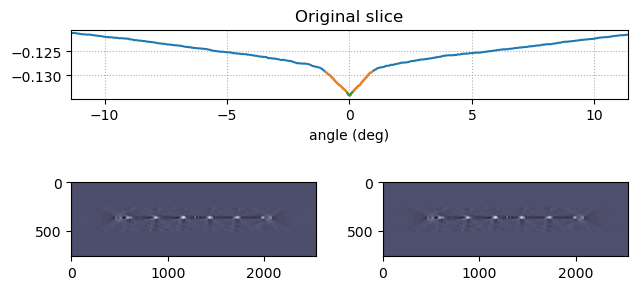

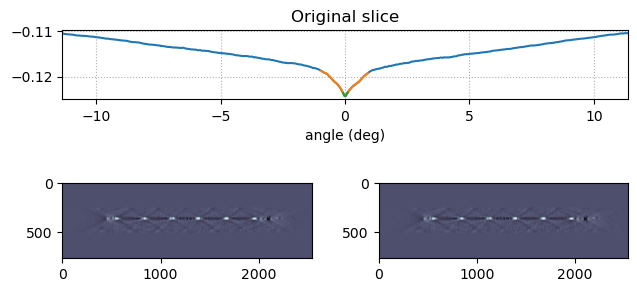

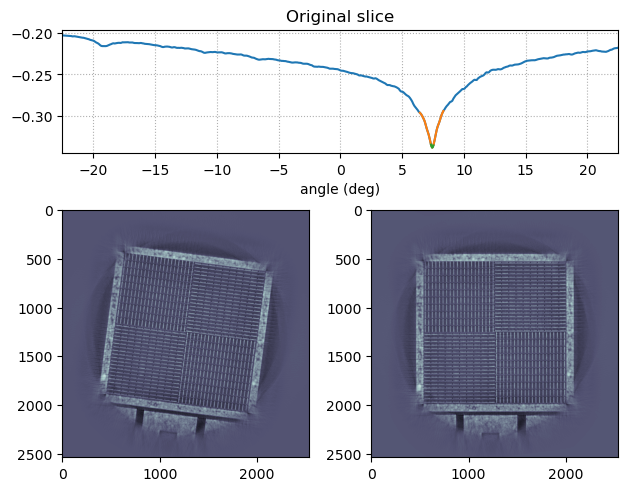

Optimal rotation values:
	x: 0.011769577860832214
	y: 0.0007695782114751637
	z: 7.4508795738220215


In [338]:
# rotate tomogram
task.phase_projections.volume.get_optimal_rotation_of_reconstruction()

In [341]:
ci_test_helper.save_or_compare_results(
    task.phase_projections.volume.optimal_rotation_angles,
    "tomogram_rotation_angles",
    atol=0.05,
    rtol=0.05,
)


tomogram_rotation_angles.h5/array PASSED


In [342]:
task.phase_projections.volume.rotate_reconstruction()

image_rotate_fft: 100%|█████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]

Rotated reconstruction by:
	x: 0.011769577860832214
	y: 0.0007695782114751637
	z: 7.4508795738220215


In [363]:
if ci_test_helper.options.update_tester_results:
    task.phase_projections.volume.save_as_tiff(
        os.path.join(ci_test_helper.extra_results_folder, "pma_aligned_rotated_volume.tiff"),
        min=-0.022,
        max=0.025,
    )

In [365]:
ci_test_helper.save_or_compare_results(
    task.phase_projections.volume.data[::s, ::s, ::s],
    "pma_aligned_rotated_volume",
)

updated saved data for "pma_aligned_rotated_volume.h5/array"


In [367]:
1

1